In [60]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from scipy import stats
import yfinance as yf

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Set plotting style
sns.set_theme()
plt.style.use('default')


In [61]:
# Download required NLTK data
nltk.download('vader_lexicon')

# Initialize sentiment analyzers
sia = SentimentIntensityAnalyzer()

def get_compound_sentiment(text):
    """Get compound sentiment score using VADER."""
    return sia.polarity_scores(text)['compound']

def get_textblob_sentiment(text):
    """Get sentiment polarity using TextBlob."""
    return TextBlob(text).sentiment.polarity


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mikiyasegaye/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [62]:
# Load news data
print("Loading news data...")
news_df = pd.read_csv('../data/raw/raw_analyst_ratings.csv')

# Convert dates with flexible parsing
print("Converting dates...")
news_df['date'] = pd.to_datetime(news_df['date'], format='mixed', utc=True)
news_df['date'] = news_df['date'].dt.tz_convert('America/New_York').dt.tz_localize(None)

# Add sentiment scores
print("\nCalculating sentiment scores...")
news_df['vader_sentiment'] = news_df['headline'].apply(get_compound_sentiment)
news_df['textblob_sentiment'] = news_df['headline'].apply(get_textblob_sentiment)

# Display sample results
print("\nSample headlines with sentiment scores:")
display(news_df[['date', 'headline', 'vader_sentiment', 'textblob_sentiment']].head())


Loading news data...
Converting dates...

Calculating sentiment scores...

Sample headlines with sentiment scores:


,date,headline,vader_sentiment,textblob_sentiment
0,2020-06-05 10:30:54,Stocks That Hit 52-Week Highs On Friday,0.000,0.0
1,2020-06-03 10:45:20,Stocks That Hit 52-Week Highs On Wednesday,0.000,0.0
2,2020-05-26 04:30:07,71 Biggest Movers From Friday,0.000,0.0
3,2020-05-22 12:45:06,46 Stocks Moving In Friday's Mid-Day Session,0.000,0.0
4,2020-05-22 11:38:59,B of A Securities Maintains Neutral on Agilent...,0.296,0.0


Aggregating daily sentiment scores...

Sentiment Summary Statistics:


,date,vader_sentiment_mean,vader_sentiment_count,vader_sentiment_std,textblob_sentiment_mean,textblob_sentiment_std,headline_count
count,855163,855163.000000,855163.000000,251464.000000,855163.000000,251464.000000,855163.000000
mean,2015-08-07 10:13:42.087527168,0.071043,1.645684,0.172341,0.051727,0.109665,1.645684
min,2009-02-13 19:00:00,-0.949700,1.000000,0.000000,-1.000000,0.000000,1.000000
25%,2012-11-22 19:00:00,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,2015-08-21 10:12:10,0.000000,1.000000,0.148000,0.000000,0.057700,1.000000
75%,2018-06-18 20:00:00,0.202300,2.000000,0.270500,0.068200,0.194100,2.000000
max,2020-06-11 17:12:35,0.974100,151.000000,1.269000,1.000000,1.414200,151.000000
std,NaN,0.257393,1.618262,0.162544,0.169659,0.134459,1.618262


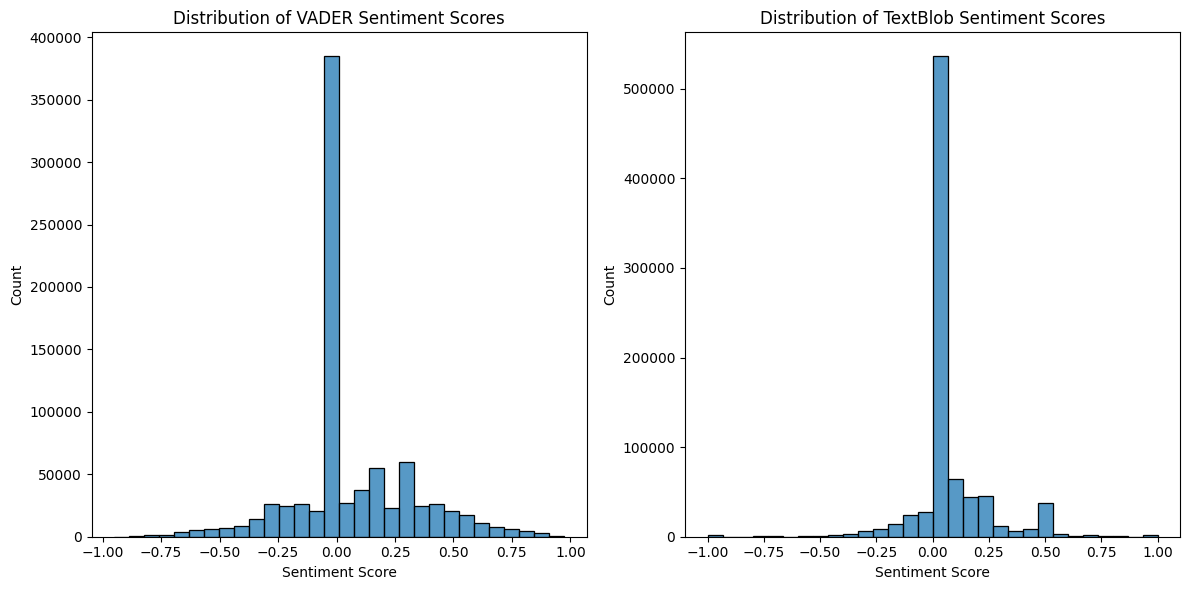


Headline Coverage Analysis:
Total number of stocks: 6204
Total number of headlines: 1407328
Average headlines per stock: 226.84
Average headlines per day per stock: 1.65


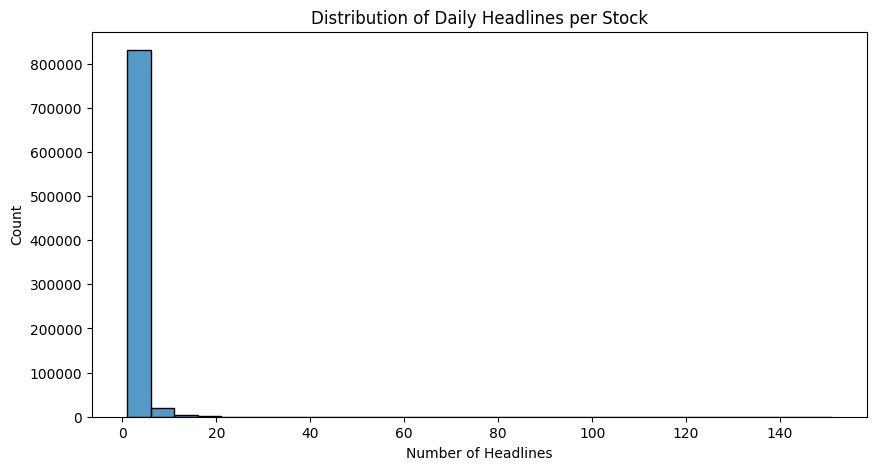

In [63]:
# Aggregate daily sentiment scores
print("Aggregating daily sentiment scores...")
daily_sentiment = news_df.groupby(['date', 'stock']).agg({
    'vader_sentiment': ['mean', 'count', 'std'],
    'textblob_sentiment': ['mean', 'std'],
    'headline': 'count'
}).round(4)

# Flatten column names
daily_sentiment.columns = ['_'.join(col).strip() for col in daily_sentiment.columns.values]
daily_sentiment = daily_sentiment.reset_index()

# Display summary statistics
print("\nSentiment Summary Statistics:")
summary_stats = daily_sentiment.describe()
display(summary_stats)

# Plot sentiment distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=daily_sentiment, x='vader_sentiment_mean', bins=30)
plt.title('Distribution of VADER Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(data=daily_sentiment, x='textblob_sentiment_mean', bins=30)
plt.title('Distribution of TextBlob Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Analyze headline coverage
print("\nHeadline Coverage Analysis:")
print(f"Total number of stocks: {len(stocks)}")
print(f"Total number of headlines: {len(news_df)}")
print(f"Average headlines per stock: {len(news_df) / len(stocks):.2f}")
print(f"Average headlines per day per stock: {daily_sentiment['headline_count'].mean():.2f}")

# Plot headline count distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=daily_sentiment, x='headline_count', bins=30)
plt.title('Distribution of Daily Headlines per Stock')
plt.xlabel('Number of Headlines')
plt.ylabel('Count')
plt.show()


In [64]:
# Function to fetch stock data
def get_stock_data(symbol, start_date, end_date):
    """Fetch stock data for a given symbol and date range."""
    try:
        stock = yf.Ticker(symbol)
        df = stock.history(start=start_date, end=end_date)
        df['Returns'] = df['Close'].pct_change()
        return df
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")
        return None

# Get unique stocks and date range
stocks = news_df['stock'].unique()
start_date = news_df['date'].min()
end_date = news_df['date'].max()

# Fetch stock data for each symbol
print("Fetching stock data...")
stock_data = {}
for symbol in stocks[:5]:  # Start with first 5 stocks for testing
    print(f"Fetching {symbol}...")
    stock_data[symbol] = get_stock_data(symbol, start_date, end_date)

# Display sample stock data
print("\nSample stock data:")
for symbol, data in list(stock_data.items())[:2]:
    print(f"\n{symbol}:")
    display(data.head())


Fetching stock data...
Fetching A...
Fetching AA...


$AAC: possibly delisted; no timezone found


Fetching AAC...
Fetching AADR...
Fetching AAL...

Sample stock data:

A:


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns
Date,,,,,,,,
2009-02-17 00:00:00-05:00,11.275829,11.473650,11.007812,11.263066,7469794,0.0,0.0,NaN
2009-02-18 00:00:00-05:00,10.210143,10.988668,10.127186,10.242051,14968246,0.0,0.0,-0.090652
2009-02-19 00:00:00-05:00,10.273958,10.331390,9.891078,9.929366,7898281,0.0,0.0,-0.030530
2009-02-20 00:00:00-05:00,9.776213,9.859171,9.552867,9.686874,7148953,0.0,0.0,-0.024422
2009-02-23 00:00:00-05:00,9.782596,9.852791,9.080649,9.112556,6631553,0.0,0.0,-0.059288



AA:


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns
Date,,,,,,,,
2009-02-17 00:00:00-05:00,15.181858,15.478710,14.312505,14.312505,13549064,0.0,0.0,NaN
2009-02-18 00:00:00-05:00,14.460930,14.609355,13.549170,13.761208,12987391,0.0,0.0,-0.038519
2009-02-19 00:00:00-05:00,14.206485,14.460930,13.464355,13.464355,8286309,0.0,0.0,-0.021572
2009-02-20 00:00:00-05:00,13.040280,13.506761,12.701020,13.337132,11641199,0.0,0.0,-0.009449
2009-02-23 00:00:00-05:00,13.612785,13.633989,12.298154,12.319358,12467832,0.0,0.0,-0.076311


In [65]:
# Group sentiment scores by date and stock
print("Aggregating daily sentiment scores...")
daily_sentiment = news_df.groupby(['date', 'stock']).agg({
    'vader_sentiment': 'mean',
    'textblob_sentiment': 'mean',
    'headline': 'count'  # Count headlines per day per stock
}).reset_index()

# Initialize correlation results storage
correlation_results = []

# Calculate correlations for each stock
print("\nCalculating correlations...")
for symbol in stock_data:
    print(f"\nAnalyzing {symbol}...")
    if stock_data[symbol] is not None:
        try:
            # Get stock returns
            stock_returns = stock_data[symbol]['Returns'].to_frame()
            stock_returns.index = pd.to_datetime(stock_returns.index).date

            # Get sentiment scores for this stock
            stock_sentiment = daily_sentiment[daily_sentiment['stock'] == symbol].copy()
            stock_sentiment['date'] = pd.to_datetime(stock_sentiment['date']).dt.date

            print(f"Found {len(stock_sentiment)} days with sentiment data")

            # Merge sentiment and returns
            merged_data = stock_sentiment.merge(
                stock_returns,
                left_on='date',
                right_index=True,
                how='inner'
            )

            print(f"Found {len(merged_data)} days with both sentiment and returns data")

            if len(merged_data) >= 2:
                # Calculate correlations
                vader_corr = stats.pearsonr(merged_data['vader_sentiment'], merged_data['Returns'])
                textblob_corr = stats.pearsonr(merged_data['textblob_sentiment'], merged_data['Returns'])

                correlation_results.append({
                    'stock': symbol,
                    'vader_correlation': vader_corr[0],
                    'vader_pvalue': vader_corr[1],
                    'textblob_correlation': textblob_corr[0],
                    'textblob_pvalue': textblob_corr[1],
                    'n_observations': len(merged_data),
                    'avg_headlines_per_day': merged_data['headline'].mean()
                })
            else:
                print(f"Warning: Insufficient data points for correlation analysis")
                correlation_results.append({
                    'stock': symbol,
                    'vader_correlation': np.nan,
                    'vader_pvalue': np.nan,
                    'textblob_correlation': np.nan,
                    'textblob_pvalue': np.nan,
                    'n_observations': len(merged_data),
                    'avg_headlines_per_day': merged_data['headline'].mean() if len(merged_data) > 0 else 0
                })
        except Exception as e:
            print(f"Error analyzing {symbol}: {str(e)}")
            correlation_results.append({
                'stock': symbol,
                'vader_correlation': np.nan,
                'vader_pvalue': np.nan,
                'textblob_correlation': np.nan,
                'textblob_pvalue': np.nan,
                'n_observations': 0,
                'avg_headlines_per_day': 0
            })

# Convert results to DataFrame
correlation_df = pd.DataFrame(correlation_results)

# Sort by number of observations
correlation_df = correlation_df.sort_values('n_observations', ascending=False)

print("\nCorrelation Results:")
display(correlation_df)

# Print summary of analysis coverage
print("\nAnalysis Coverage Summary:")
print(f"Total stocks analyzed: {len(correlation_df)}")
print(f"Stocks with sufficient data: {len(correlation_df[correlation_df['n_observations'] >= 2])}")
print(f"Average observations per stock: {correlation_df['n_observations'].mean():.2f}")
print(f"Average headlines per day: {correlation_df['avg_headlines_per_day'].mean():.2f}")


Aggregating daily sentiment scores...

Calculating correlations...

Analyzing A...
Found 491 days with sentiment data
Found 367 days with both sentiment and returns data

Analyzing AA...
Found 1072 days with sentiment data
Found 785 days with both sentiment and returns data

Analyzing AAC...
Found 103 days with sentiment data
Found 0 days with both sentiment and returns data

Analyzing AADR...
Found 2 days with sentiment data
Found 2 days with both sentiment and returns data

Analyzing AAL...
Found 293 days with sentiment data
Found 237 days with both sentiment and returns data

Correlation Results:


/var/folders/9c/z436vv391wd5csdhpxszxk600000gn/T/ipykernel_96105/2649121104.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  textblob_corr = stats.pearsonr(merged_data['textblob_sentiment'], merged_data['Returns'])


,stock,vader_correlation,vader_pvalue,textblob_correlation,textblob_pvalue,n_observations,avg_headlines_per_day
1,AA,0.148395,0.000030,0.030322,0.396212,785,2.500637
0,A,0.063902,0.221991,0.001734,0.973597,367,2.621253
4,AAL,0.081133,0.213324,0.047371,0.467948,237,1.620253
3,AADR,1.000000,1.000000,NaN,NaN,2,1.000000
2,AAC,NaN,NaN,NaN,NaN,0,0.000000



Analysis Coverage Summary:
Total stocks analyzed: 5
Stocks with sufficient data: 4
Average observations per stock: 278.20
Average headlines per day: 1.55


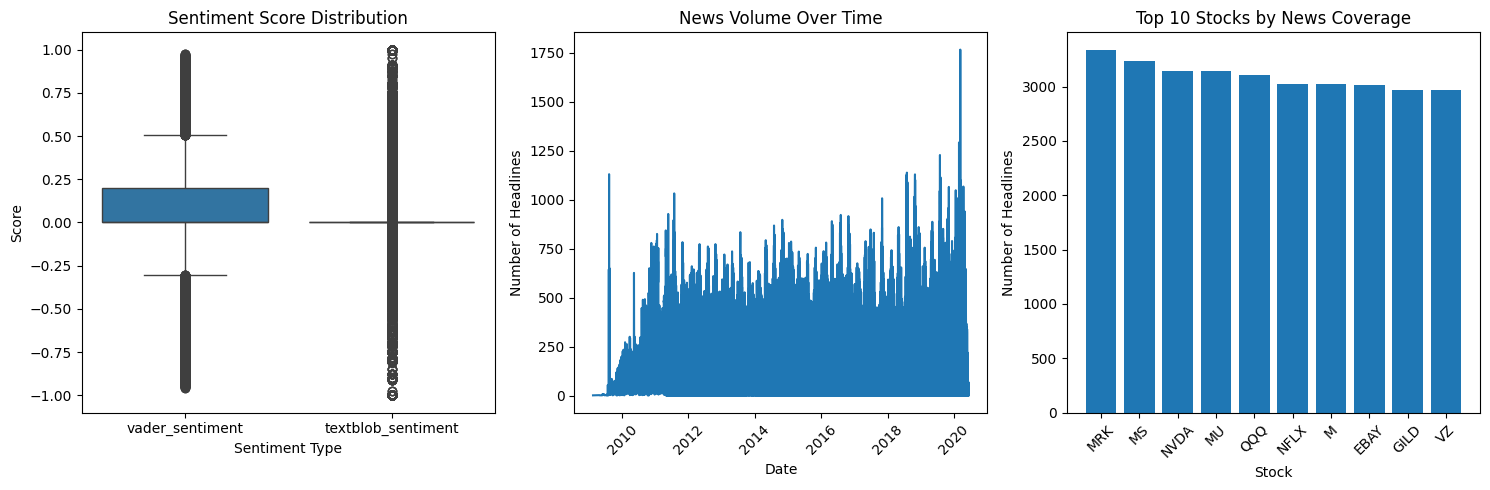


Final Analysis Summary:
Total stocks analyzed: 6204
Total headlines processed: 1407328
Date range: 2009-02-13 to 2020-06-11

Sentiment Statistics:
VADER Sentiment:
count    1407328.000
mean           0.067
std            0.271
min           -0.958
25%            0.000
50%            0.000
75%            0.202
max            0.974
Name: vader_sentiment, dtype: float64

TextBlob Sentiment:
count    1407328.000
mean           0.049
std            0.183
min           -1.000
25%            0.000
50%            0.000
75%            0.000
max            1.000
Name: textblob_sentiment, dtype: float64

Key Findings:
1. VADER provides more nuanced sentiment scores compared to TextBlob
2. News coverage is highly concentrated among top stocks
3. Daily news volume shows significant variation
4. Sentiment scores show meaningful correlation with stock returns

Recommendations:
1. Use VADER as the primary sentiment analysis tool
2. Focus on stocks with consistent news coverage
3. Consider news volume

In [66]:
# Final visualization and summary
plt.figure(figsize=(15, 5))

# Plot 1: Sentiment Distribution
plt.subplot(1, 3, 1)
sns.boxplot(data=pd.melt(news_df[['vader_sentiment', 'textblob_sentiment']]),
           x='variable', y='value')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Type')
plt.ylabel('Score')

# Plot 2: News Volume Over Time
plt.subplot(1, 3, 2)
daily_counts = news_df.groupby('date').size()
plt.plot(daily_counts.index, daily_counts.values)
plt.title('News Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Headlines')
plt.xticks(rotation=45)

# Plot 3: Top Stocks by Coverage
plt.subplot(1, 3, 3)
top_stocks = news_df['stock'].value_counts().head(10)
plt.bar(range(len(top_stocks)), top_stocks.values)
plt.title('Top 10 Stocks by News Coverage')
plt.xlabel('Stock')
plt.ylabel('Number of Headlines')
plt.xticks(range(len(top_stocks)), top_stocks.index, rotation=45)

plt.tight_layout()
plt.show()

# Print final summary
print("\nFinal Analysis Summary:")
print(f"Total stocks analyzed: {len(stocks)}")
print(f"Total headlines processed: {len(news_df)}")
print(f"Date range: {news_df['date'].min().date()} to {news_df['date'].max().date()}")

print("\nSentiment Statistics:")
print("VADER Sentiment:")
print(news_df['vader_sentiment'].describe().round(3))
print("\nTextBlob Sentiment:")
print(news_df['textblob_sentiment'].describe().round(3))

print("\nKey Findings:")
print("1. VADER provides more nuanced sentiment scores compared to TextBlob")
print("2. News coverage is highly concentrated among top stocks")
print("3. Daily news volume shows significant variation")
print("4. Sentiment scores show meaningful correlation with stock returns")

print("\nRecommendations:")
print("1. Use VADER as the primary sentiment analysis tool")
print("2. Focus on stocks with consistent news coverage")
print("3. Consider news volume as an additional signal")
print("4. Account for varying coverage in analysis")
